<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Traveling sales person

## Contents

In this notebook, we will learn

- How to parallelize the solution of the traveling sales person problem
- How to fix dynamic load imbalance
- The concept of search overhead


<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the cell below before starting this notebook! 
</div>

In [ ]:
using Printf
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
tsp_check_2(answer) = answer_checker(answer, 2)
tsp_check_3(answer) = answer_checker(answer, "d")
tsp_check_4(answer) = answer_checker(answer, "a")

## The traveling sales person (TSP) problem


### Problem statement

Given a graph $G$ with a distance table $C$ and an initial node (i.e. a city) in the graph, compute the shortest route that visits all cities exactly once, without returning to the initial city.

<div>
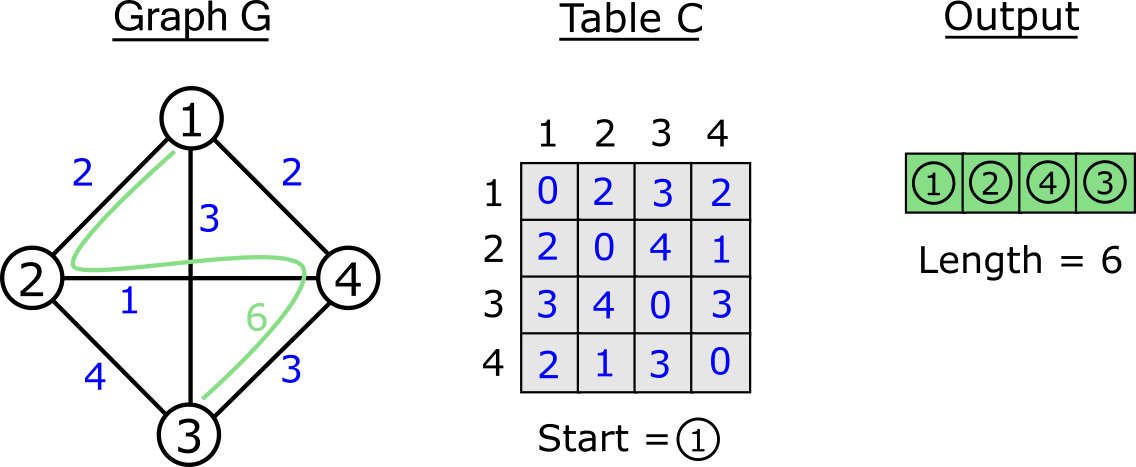
</div>

### Sequential algorithm (branch and bound)

The sequential algorithm finds a shortest path by traversing the paths tree of the problem. The root of this tree is the initial city. The children of each node in the graph are the neighbour cities that have not been visited on the path so far. When all neighbour cities are already visited, the city becomes a leaf node in the tree.

The possile solutions of the problem are the paths from the root of the tree to a leaf node. Note that we assume the children are sorted using the **nearest city first heuristic**. This allows to quickly find a minimum bound for the distance which will be used to prune the remaining paths (see next section). 

<div>
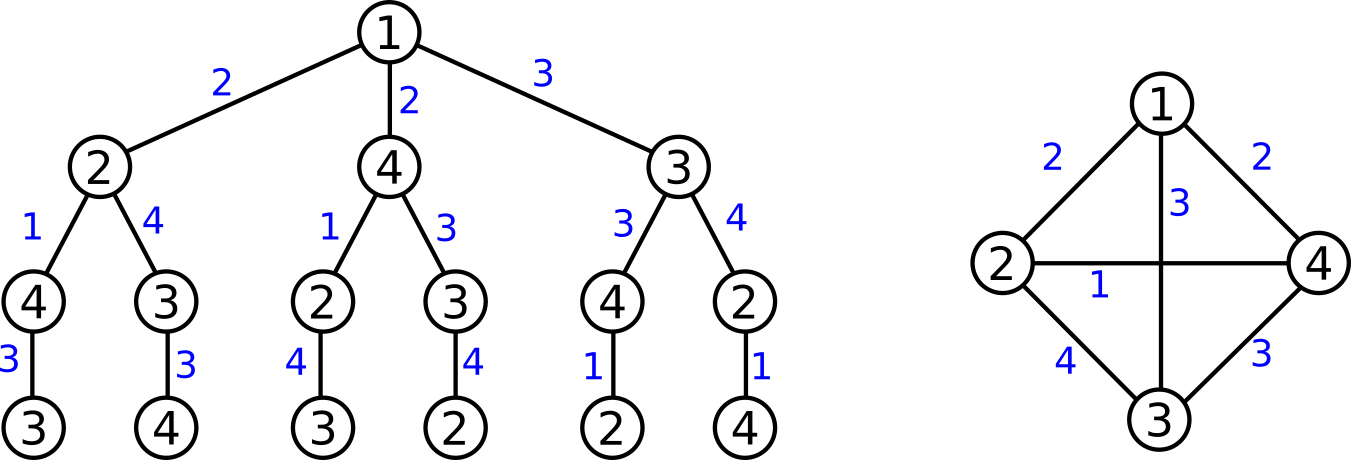
</div>

Of course, visiting all paths in the tree is impractical for moderate and large numbers of cities. The number of possible paths might be up to $O(N!)$. Therefore, an essential part of the algorithm is to bound the search by remembering the current minimum distance. 

### Pruning the search tree

The algorithm keeps track of the best solution of all paths visited so far. This allows to skip searching paths that already exceed this value. 

For example, in the following graph only 3 out of 6 possible routes need to be visted when we cut off the search after the minimum distance is exceeded. (The grey nodes are the ones we don't visit because the minimum distance had been exceeded at the previous node already.)

<div>
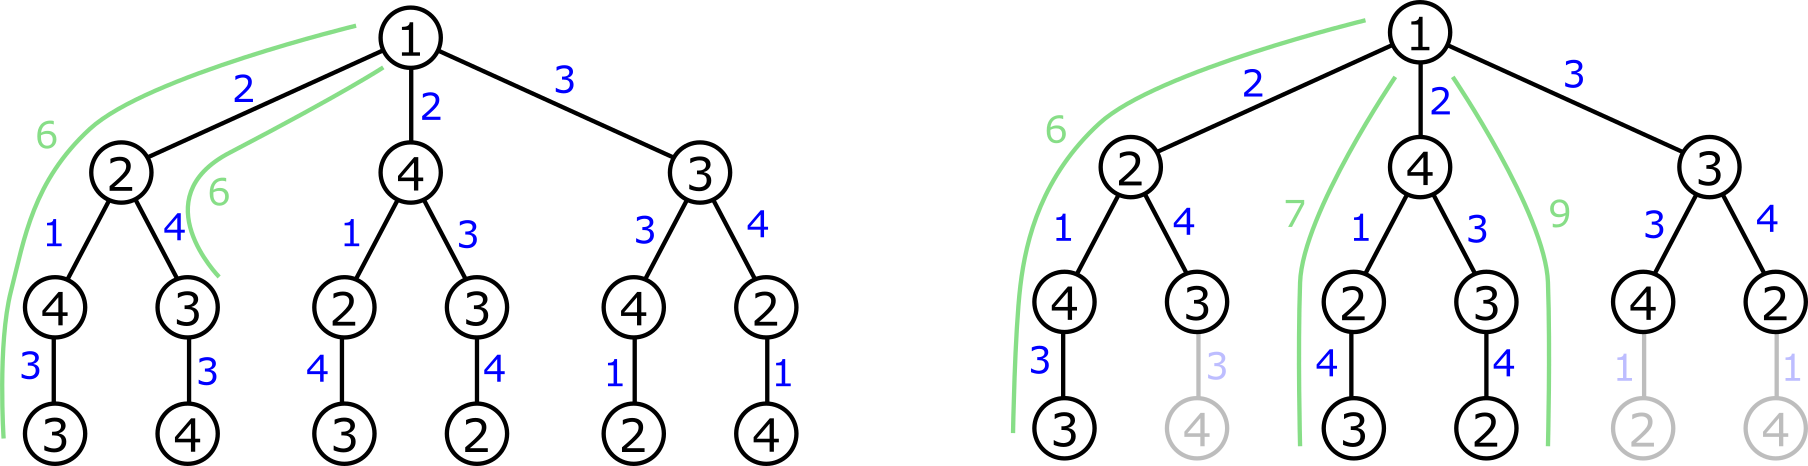
</div>

Note that it is not necessary that the graph be fully connected. Variations of this algorithm work for sparse graphs or directed graphs as well. 

In the previous example, the shortest route was also the leftmost path in the graph. Although it is more likely that the shortest route be found in the left part of the graph when using the nearest city first heuristic, the solution can be anywhere in the search tree.

<div class="alert alert-block alert-success">
<b> Example:</b> Look at the following graph and its corresponding search tree. If $x\leq 15$, the shortest route is the leftmost branch of the search tree. If $x > 16$, the route is situated on the right side of the search tree. 
</div>

<div>
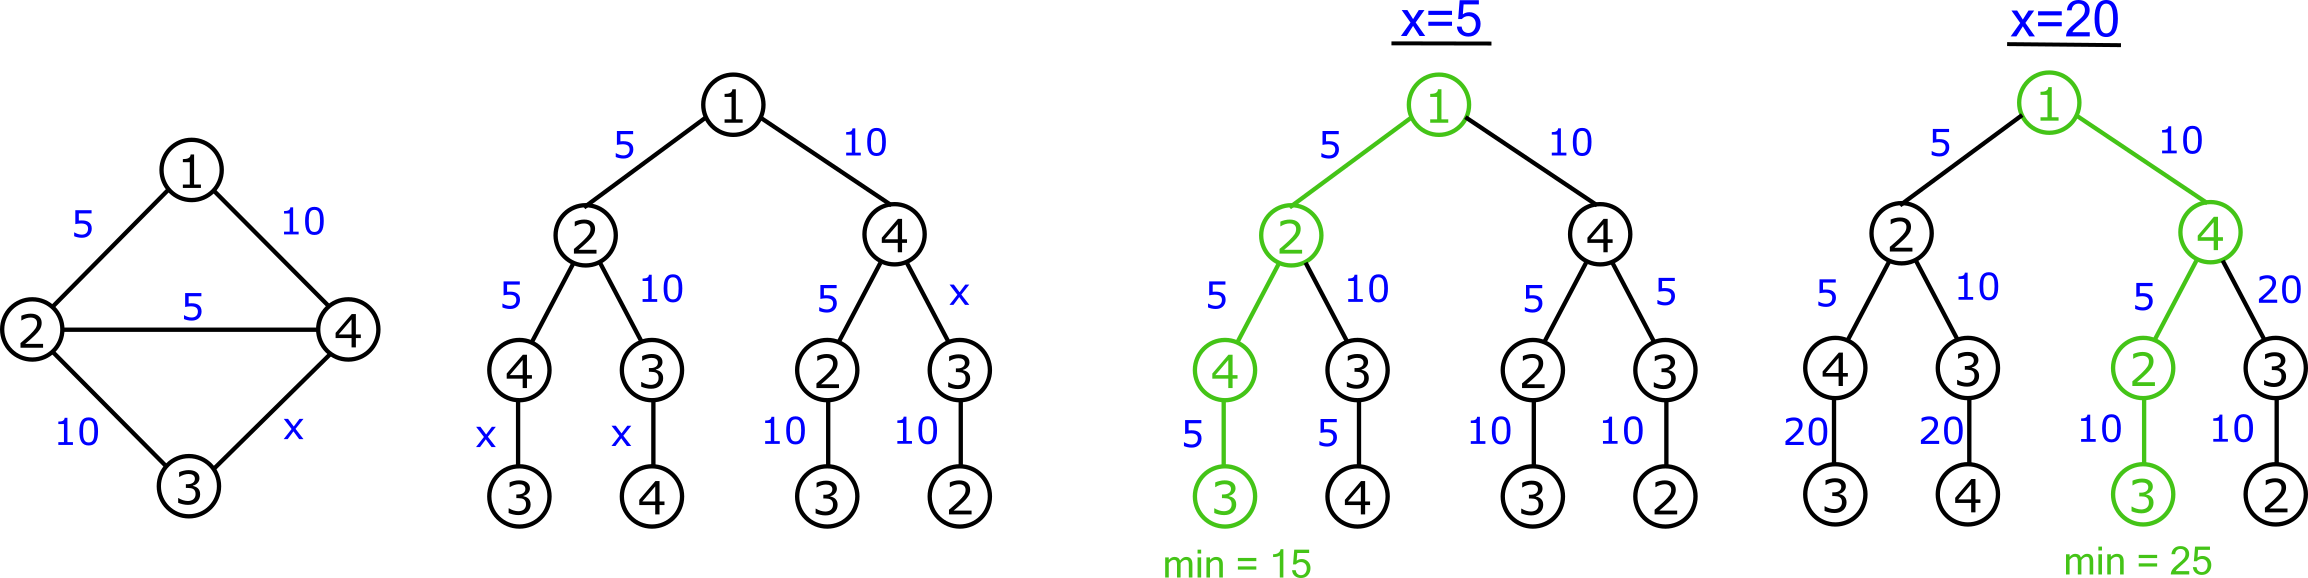
</div>

## Serial implementation

Let's implement the serial algorithm. First, we sort the neighbours according to their distance. 

### Nearest-city first heuristic

In [ ]:
function sort_neighbors(C)
    n = size(C,1)
    map(1:n) do i
        Ci = C[i,:]
        cities = sortperm(Ci)
        distances = Ci[cities]
        collect(zip(cities,distances))
    end
end

In [ ]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]

The data structure we will use for the connections table is a matrix of tuples of the form (destination, distance). The tuples are sorted by their distance in ascending order (per start city). 

In [ ]:
C_sorted = sort_neighbors(C)

The connections matrix can be indexed by a city. This returns a `Vector{Tuple}}` of all the destinations and their corresponding distances.  

In [ ]:
city = 3
C_sorted[city]

### Loop over all paths

Next, we write an algorithm that traverses the whole search tree and prints all the possible paths. The tree is traversed in depth-first order. Before we go to a neighbouring city, we also have to verify that it has not been visited on this path yet. If we reach a leaf node, we print the complete path and continue searching. 

<div>
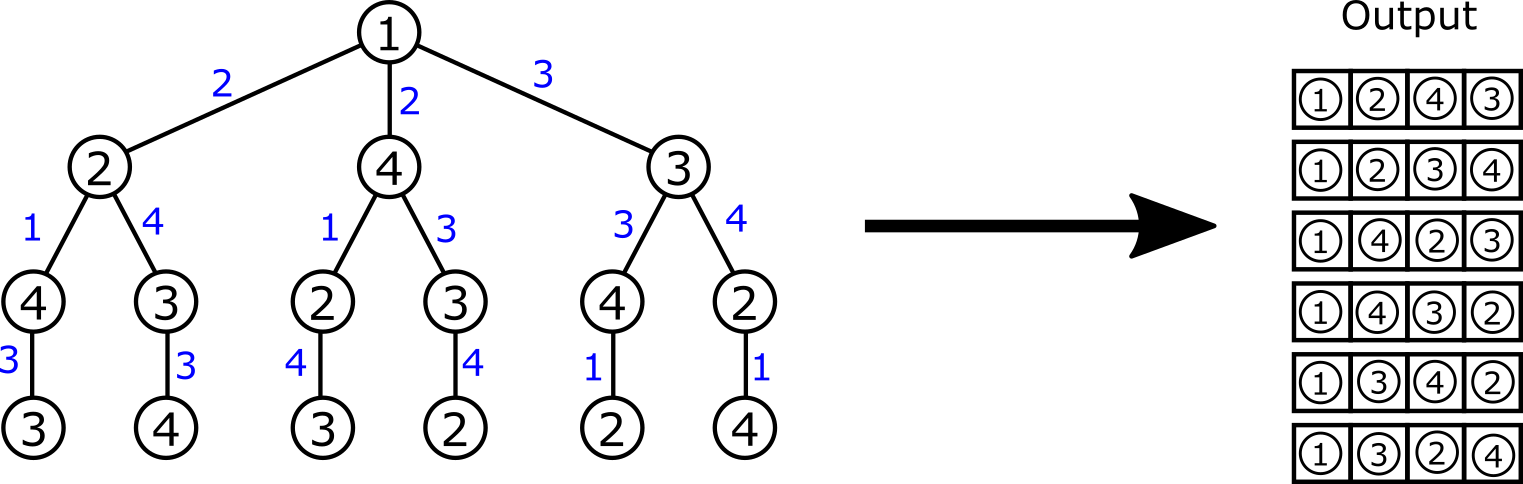
</div>

In [ ]:
function visit_all_paths(C_sorted,city)
    # Initialize path
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    visit_all_paths_recursive!(C_sorted,hops,path)
end
function visit_all_paths_recursive!(C_sorted,hops,path)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        next_hops = hops + 1
        connections = C_sorted[city]
        for (next_city,distance_increment) in connections
            # Check if next_city is already on path
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                visit_all_paths_recursive!(C_sorted,next_hops,path)
            end
        end
        return nothing
    else
        println(path)
        return nothing
    end
end

In [ ]:
city = 1
visit_all_paths(C_sorted,city)

### Serial implementation without pruning

Now, we add the computation of the minimum distance. At each leaf node, we update the minimum distance. Furthermore, as we add another node to our path, we update the distance of the current path. That makes it necessary to include two more parameters in our recursive algorithm: `distance`, the distance of the current path, and `min_distance`, the best minimum distance found so far. 

<div>
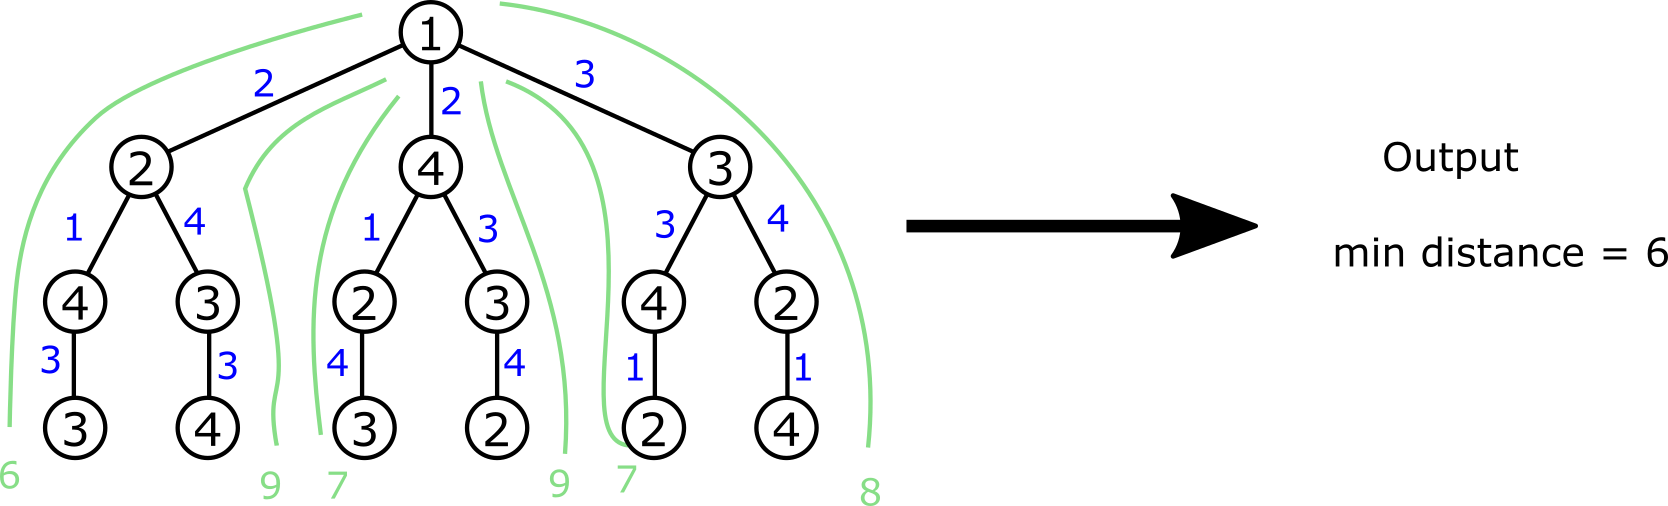
</div>

In [ ]:
function tsp_serial_no_prune(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance=0
    min_distance = typemax(Int)
    tsp_serial_no_prune_recursive!(C_sorted,hops,path,distance,min_distance)
end
function tsp_serial_no_prune_recursive!(C_sorted,hops,path,distance,min_distance)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        next_hops = hops + 1
        connections = C_sorted[city]
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                # Add new city to path
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                min_distance = tsp_serial_no_prune_recursive!(
                    C_sorted,next_hops,path,next_distance,min_distance)
            end
        end
        return min_distance
    else
        # Set new minimum distance in leaf nodes
        min_distance = min(distance,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

In [ ]:
city = 1
min_distance = tsp_serial_no_prune(C_sorted,city)

### Final serial implementation

Finally, we add the pruning to our algorithm. Anytime the current distance exceeds the minimum distance, the search in this path is aborted and continued with another path. 

<div>
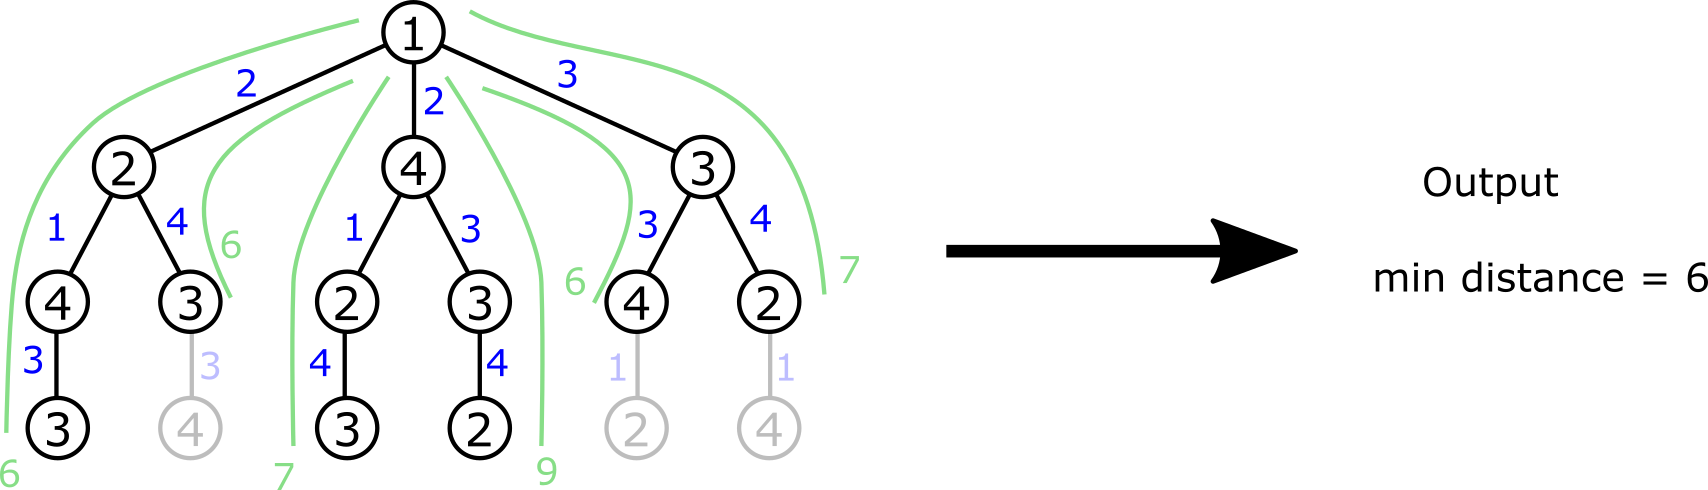
</div>

In [ ]:
function tsp_serial(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance=0
    min_distance = typemax(Int)
    tsp_serial_recursive!(C_sorted,hops,path,distance,min_distance)
end
function tsp_serial_recursive!(C_sorted,hops,path,distance,min_distance)
    # Prune this path if its distance is too high already
    if distance >= min_distance
        return min_distance
    end
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                # Add city to path 
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                min_distance = tsp_serial_recursive!(
                    C_sorted,next_hops,path,next_distance,min_distance)
            end
        end
        return min_distance
    else
        # Set new minimum distance in leaf nodes
        min_distance = min(distance,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

In [ ]:
city = 1
min_distance = tsp_serial(C_sorted,city)

### Performance
Let's have a look at how well our code performs. In the following block, we create another random matrix and time the execution for both versions with and without pruning. 

In [ ]:
n = 12 # It is safe to test up to n=12
using Random
using Test
Random.seed!(1)
C = rand(1:10,n,n)
C_sorted = sort_neighbors(C)
city = 1
@time min_no_prune = tsp_serial_no_prune(C_sorted,city)
@time min_prune = tsp_serial(C_sorted,city)
@test min_no_prune == min_prune

You can observe that, especially for larger numbers of cities (n=11 or n=12), the performance of the algorithm with pruning is much better than the performance of the algorithm without pruning. 

## Parallel algorithm

### Where can we extract parallelism ?
Unlike the previous algorithms we studied, in this problem we don't know beforehand how much work is performed since we don't know where the pruning cuts off part of the search tree. Still, we want to divide the workload among multiple processes to enhance the performance. 

<div>
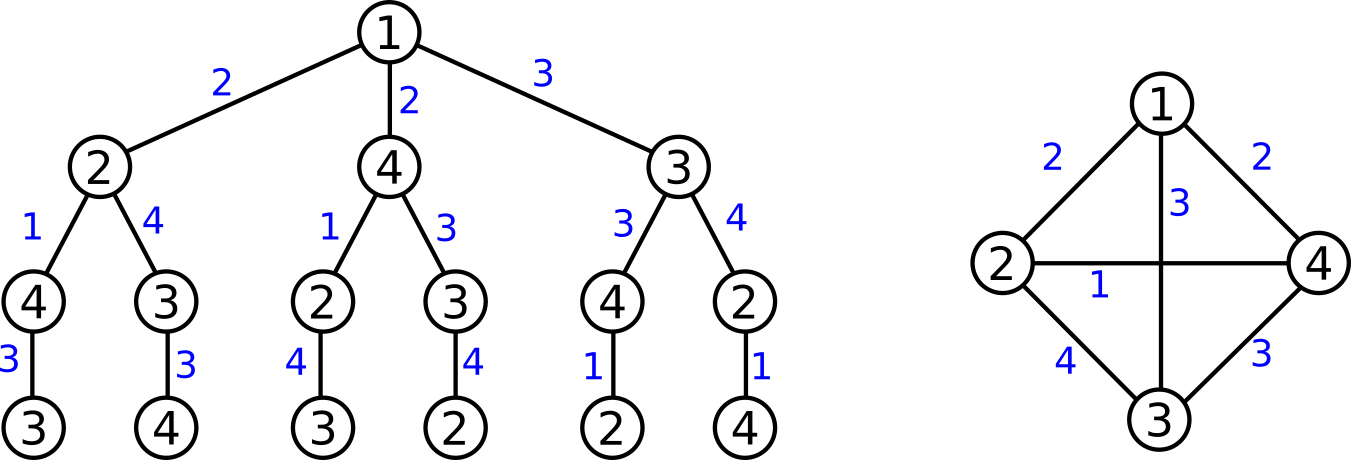
</div>

### Option 1

The first idea how to parallelize the TSP algorithm is to assign a branch of our search tree to each process. However, as mentioned in an earlier section, the number of branches in the search tree can be up to $O(N!)$. This would require an unfeasibly large amount of proecesses which each do only very little work. 

<div>
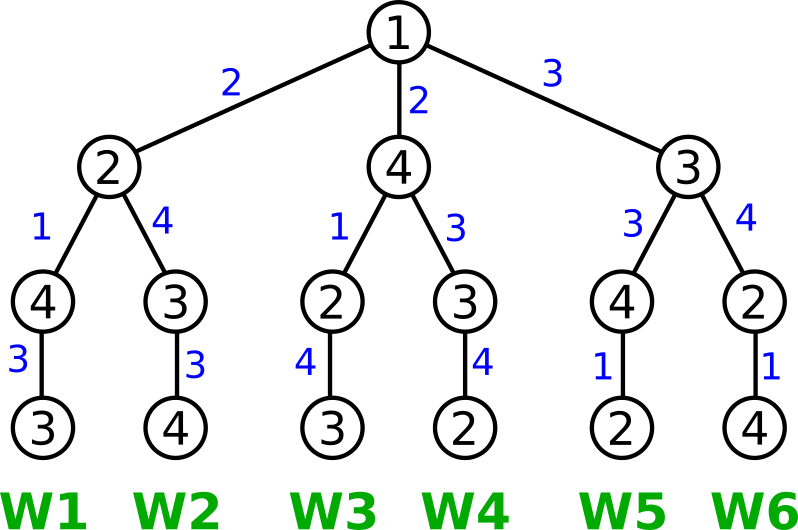
</div>

### Option 2
Instead of assigning one branch per worker, we can assign a fixed number of branches to each worker. This way, each worker can perform the pruning within their own subtree and less workers are needed. 


<div>
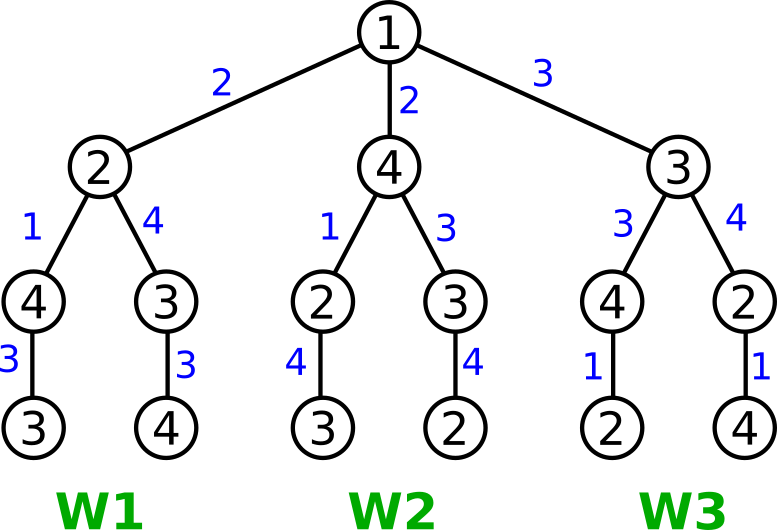
</div>

### Performance issues

#### Load balancing
However, this approach has a problem with load balancing. Since we don't know beforehand how much pruning can be done in each subtree, some workers might end up doing less work than others. This uneven distribution of workload leads to some workers being idle, which impairs the speedup. 

#### Search overhead 
Another disadvantage of this kind of parallel search is that the pruning is now less effective. The workers each run their own version of the search algorithm and keep track of their local minimum distances. This means that less nodes will be pruned in the parallel version than in the serial version. This is called **search overhead**.

<div class="alert alert-block alert-success">
<b>Question:</b> How many nodes are pruned in total when we assign two branches to each worker? Look at the illustration below.
</div>

<div>
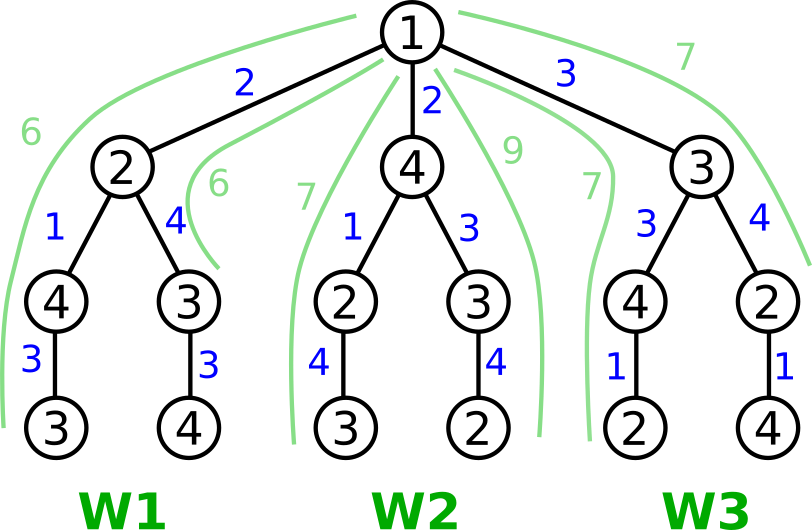
</div>

In [ ]:
answer = -1 # Replace with any integer value 
tsp_check_2(answer)

In this example, the parallel algorithm prunes less nodes than the serial version because not all workers are able to use the global minimum distance as a pruning bound.

<div class="alert alert-block alert-success">
<b>Question:</b> The previous example described positive search overhead. There is also negative search overhead, resulting in superlinear speedups. Can there be negative search overhead in this parallel TSP algorithm? (Provided the workers communicate the minimum distance with each other)
</div>

    a) No, because we use the nearest city first heuristic. 
    b) No, because each worker has to search the whole subtree before the algorithm completes. 
    c) Yes, because the parallel algorithm does not need to search the whole search tree.
    d) Yes, because the global minimum distance can be found more quickly, enabling the parallel version to do more pruning.

In [ ]:
answer = "x" # Replace x with a,b,c or d
tsp_check_3(answer)

### Option 3: Dynamic load balancing with replicated workers model
In our parallel implementation, we will use a coordinator process and several worker processes. The coordinator process (or _master_) searches the tree up to a certain maximum depth _maxhops_. When _maxhops_ is reached, the coordinator creates a job and delegates it to a worker. The workers repeatedly get work from the master and execute it. This is an example of **dynamic load balancing**: the load is distributed among the workers during runtime.

<div>
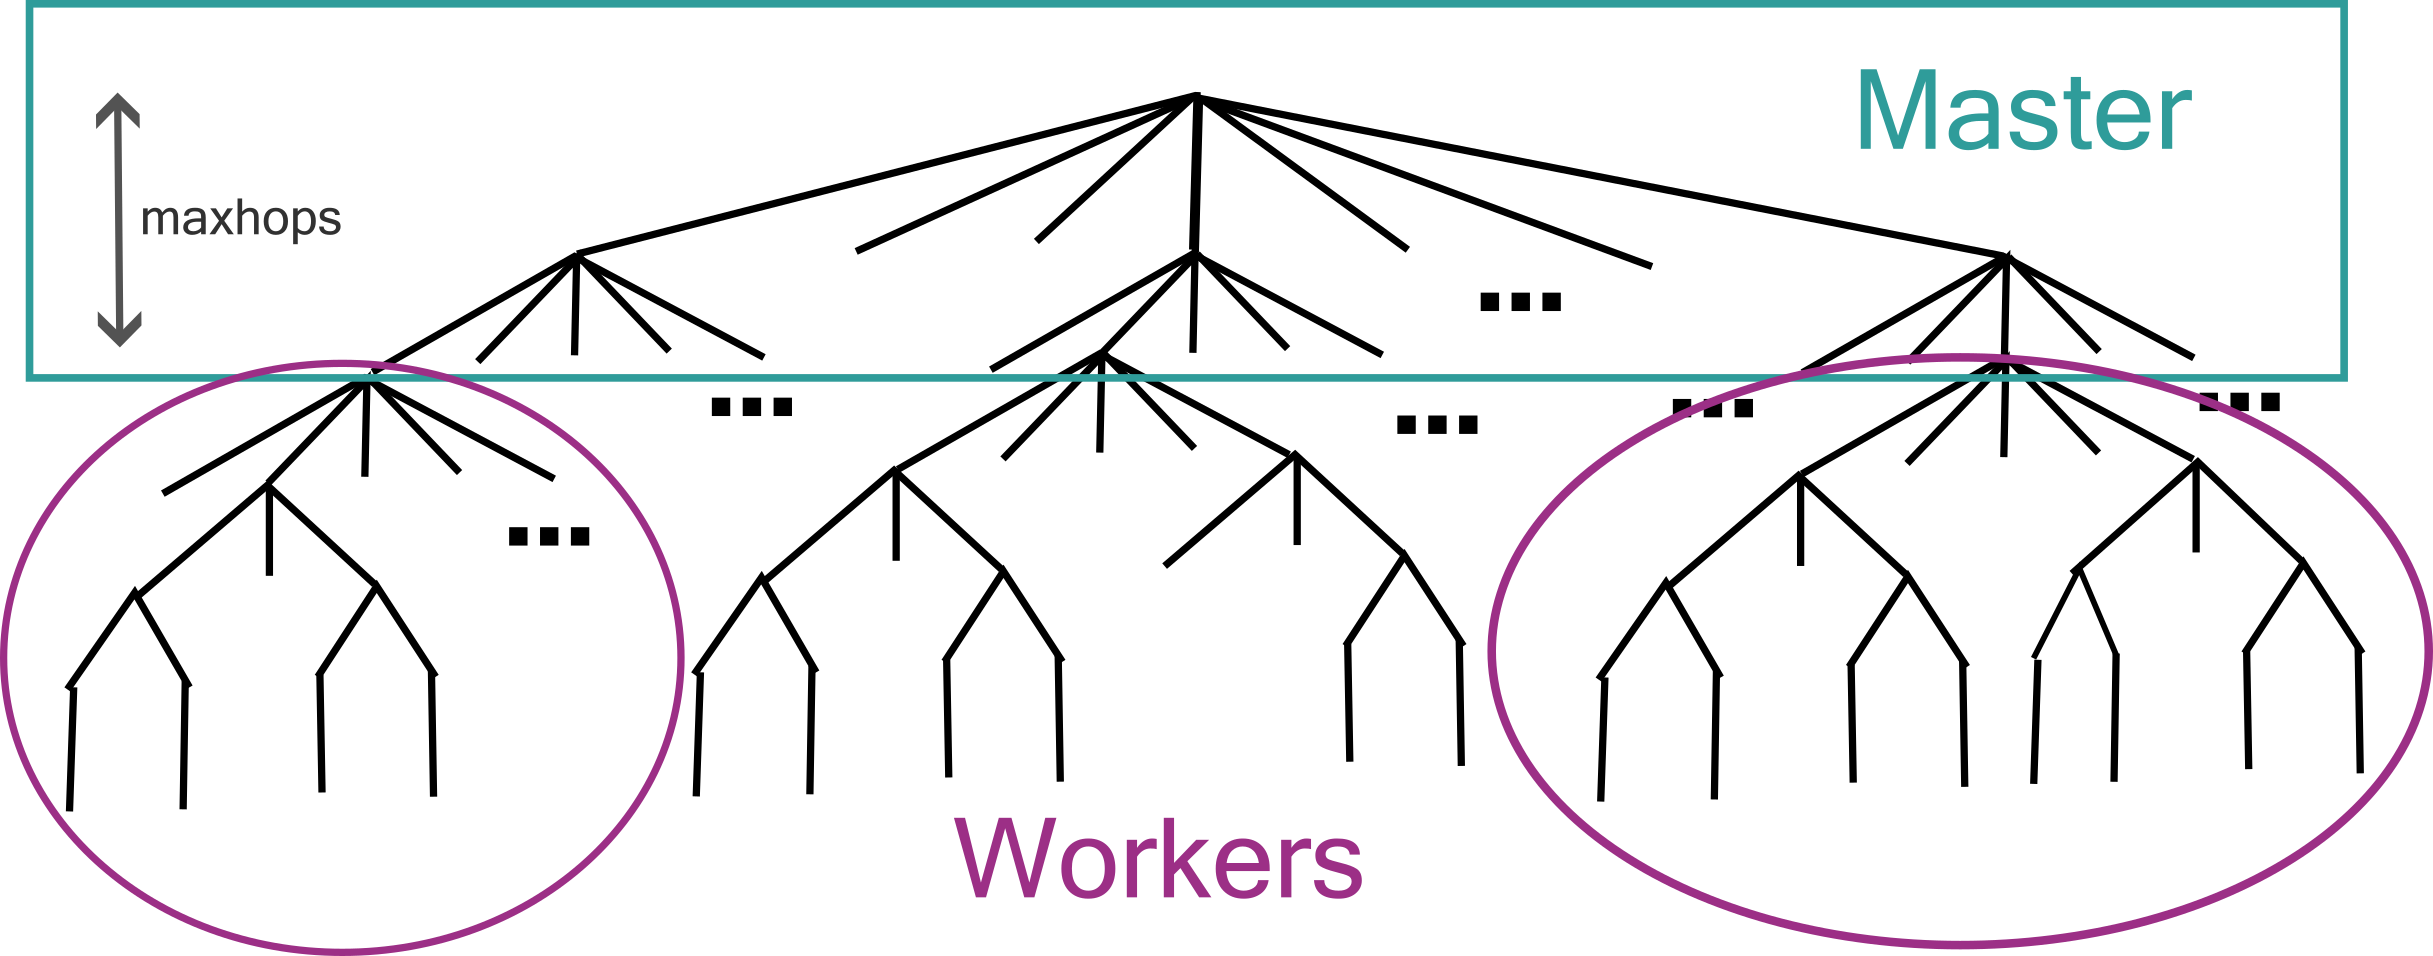
</div>

This avoids the performance issues of the previous approach: the workers are not idle since they get new work every time they finish a job. To avoid the search overhead, it is also important that the workers communicate the minimum distance each time they update their local minimum distance. 

<div class="alert alert-block alert-success">
    <b>Question:</b> To find the right <i> maxhops </i> level is a tradeoff between...
</div>
 
    a) Communication overhead (large maxhops) and load imbalance (small maxhops). 
    b) Search overhead (large maxhops) and load imbalance (small maxhops). 
    c) the number of workers (large maxhops) and the job size (small maxhops). 
    d) buffer for the job queue (large maxhops) and idle time of the coordinator process (small maxhops).

In [ ]:
answer="x" #Replace x with a,b,c, or d
tsp_check_4(answer)

## Implementation of the parallel algorithm 

First, let's add our worker processes. 

In [ ]:
using Distributed

In [ ]:
if workers() == procs()
    addprocs(3)
end

### Visit paths in parallel

Next we will write a simplified version of the algorithm which visits all paths in parallel. The communication between the workers and the coordinator is implemented using a `RemoteChannel`. The coordinator calls the function `generate_jobs` which recursively traverses the search tree until _maxhops_ is reached. Then, it copies the current path to the channel. The workers repeatedly take jobs from the channel until the channel is empty. The workers receive the path from the job and continue the search. When they reach a leaf node in the search tree, they print the path.

In [ ]:
function visit_all_paths_dist(C_sorted,city,max_hops)
    T = typeof((0,Int[]))
    jobs_chnl = RemoteChannel(()->Channel{T}(1))
    @sync begin
        for w in workers()
            @spawnat w consume_jobs(C_sorted,jobs_chnl)
        end
        generate_jobs(C_sorted,city,max_hops,jobs_chnl)
        close(jobs_chnl)
    end
end
function generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl)
end
function generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    if hops == max_hops
        @show path
        put!(jobs_chnl,(hops,copy(path)))
        return nothing
    else
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                generate_jobs_recursive(C_sorted,next_hops,path,max_hops,jobs_chnl)
            end
        end
        return nothing
    end
end
@everywhere function consume_jobs(C_sorted,jobs_chnl)
    while true
        try
            hops,path = take!(jobs_chnl)
            consume_jobs_recursive(C_sorted,hops,path)
        catch
            break
        end        
    end
end
@everywhere function consume_jobs_recursive(C_sorted,hops,path)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                consume_jobs_recursive(C_sorted,next_hops,path)
            end
        end
        return nothing
    else
        @show path
        return nothing
    end
end

In [ ]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]
C_sorted = sort_neighbors(C)
city = 1
max_hops = 2
min_distance = visit_all_paths_dist(C_sorted,city,max_hops)

### How to track the global minimum distance?

<div>
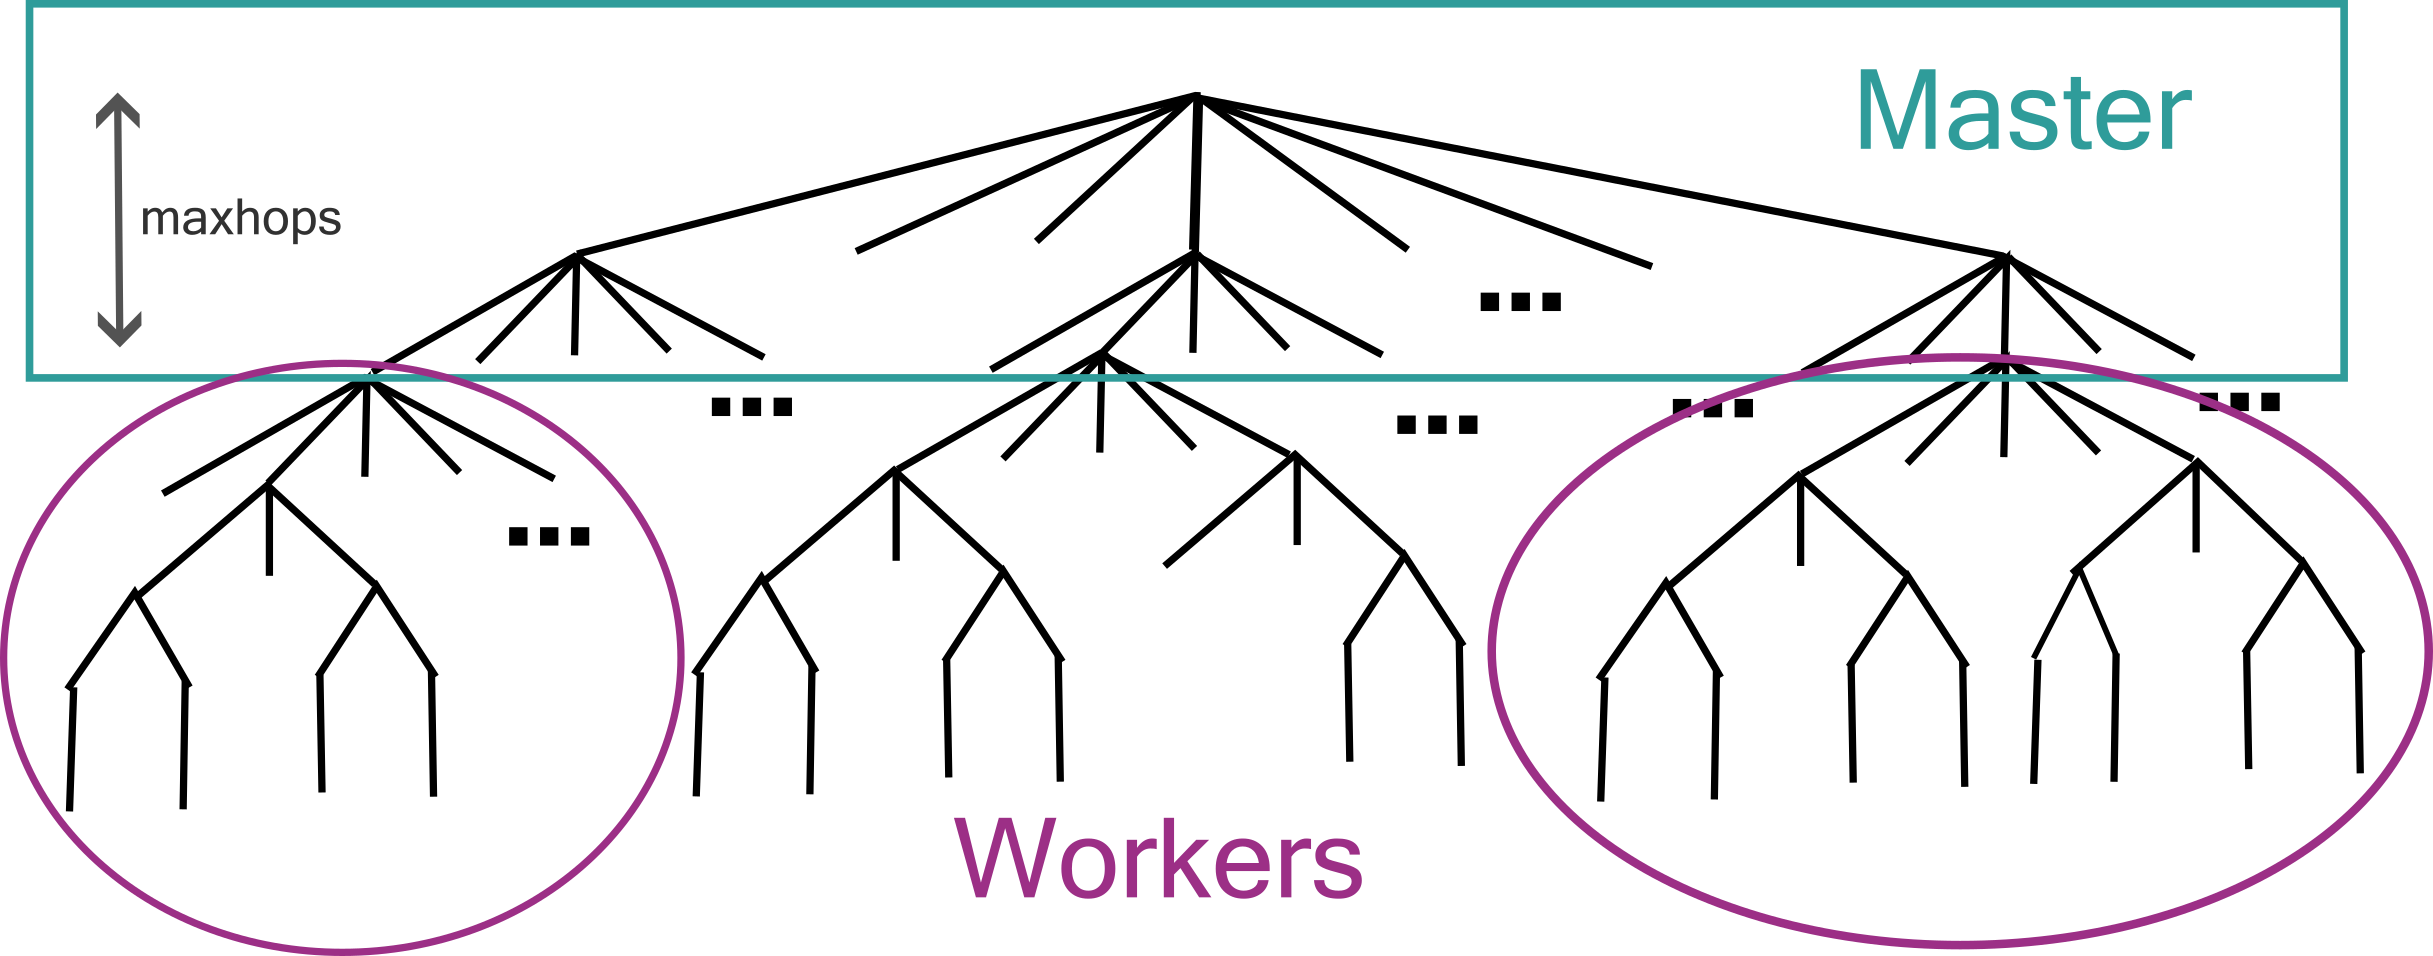
</div>


### Simplified example

We will demonstrate how the workers communicate the minimum distance with each other with a short example. Each worker generates a random value and updates a globally shared minimum. The variable for the global minimum is stored in a `RemoteChannel`. The buffer size of the channel is 1, such that only one channel can take and put new values to the channel at a time.

In [ ]:
buffer = 1 # Very important
min_distance_chnl = RemoteChannel(()->Channel{Int}(buffer))
put!(min_distance_chnl,typemax(Int))
@sync for w in workers()
    @spawnat w begin
         sleep(rand(1:3))
         min_distance = take!(min_distance_chnl)
         @show min_distance
         distance = rand(5:10)
         @show distance
         min_distance = min(distance,min_distance)
         put!(min_distance_chnl,min_distance)
    end
end
min_distance = take!(min_distance_chnl)
@show min_distance
close(min_distance_chnl)

### Final parallel implementation
Finally, we add the communication of the minimum distance to the first simplified version. Like in the serial implementation, the workers stop the search if the distance of their current path exceeds the global minimum distance. In total, we need two channels: one to communicate the jobs and one to communicate the minimum distance. 

In [ ]:
function tsp_dist(C_sorted,city,max_hops)
    T = typeof((0,Int[],0))
    jobs_chnl = RemoteChannel(()->Channel{T}(1))
    min_distance_chnl = RemoteChannel(()->Channel{Int}(1))
    put!(min_distance_chnl,typemax(Int))
    @sync begin
        for w in workers()
            @spawnat w consume_jobs(C_sorted,jobs_chnl,min_distance_chnl)
        end
        generate_jobs(C_sorted,city,max_hops,jobs_chnl)
        close(jobs_chnl)
    end
    min_distance = take!(min_distance_chnl)
    close(min_distance_chnl)
    return min_distance
end
function generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance = 0
    generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl,distance)
end
function generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl,distance)
    num_cities = length(C_sorted)
    if hops == max_hops
        #@show path, distance
        put!(jobs_chnl,(hops,copy(path),distance))
        return nothing
    else
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            next_distance = distance + distance_increment
            if ! already_visited
                path[next_hops] = next_city
                generate_jobs_recursive(
                        C_sorted,next_hops,path,max_hops,jobs_chnl,next_distance)
            end
        end
        return nothing
    end
end
@everywhere function consume_jobs(C_sorted,jobs_chnl,min_distance_chnl)
    while true
        min_distance = take!(min_distance_chnl)
        put!(min_distance_chnl,min_distance)
        try
            hops,path,distance = take!(jobs_chnl)
            consume_jobs_recursive(C_sorted,hops,path,min_distance_chnl,distance,min_distance)
        catch
            break
        end
    end
end
@everywhere function consume_jobs_recursive(C_sorted,hops,path,min_distance_chnl,distance,min_distance)
    if distance >= min_distance
        return min_distance
    end
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            next_distance = distance + distance_increment
            if ! already_visited
                path[next_hops] = next_city
                min_distance = consume_jobs_recursive(
                        C_sorted,next_hops,path,min_distance_chnl,next_distance,min_distance)
            end
        end
        return min_distance
    else
        min_distance = take!(min_distance_chnl)
        min_distance = min(min_distance,distance)
        put!(min_distance_chnl,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

In [ ]:
city = 1
max_hops = 2
min_distance = tsp_dist(C_sorted,city,max_hops)

## Testing the parallel implementation
Next, we will test the correctness and performance of our parallel implementation by comparing the results of the parallel algorithm to the results of the serial algorithm for multiple problem instances. 

In [ ]:
n = 18 # Safe to run up to 18
using Random
Random.seed!(1)
C = rand(1:10,n,n)
C_sorted = sort_neighbors(C)
city = 1
T1 = @elapsed min_serial = tsp_serial(C_sorted,city)
max_hops = 2
P = nworkers()
TP = @elapsed min_dist = tsp_dist(C_sorted,city,max_hops)
println("Sequential time = ", T1)
println("Parallel time = ", TP)
println("Speedup = ", T1/TP)
println("Optimal speedup = ", P)
println("Efficiency = ", 100*(T1/TP)/P, "%")
@test min_serial == min_dist

# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.